#  Introduction

We need to build a basket of securities that mimic the movements of target equity $y$. Therefore the ideal case is finding a function of available securities (maximum 5 securiteis) which follows the equation $y_t = f(X_t) + \epsilon_t$ starting from time $t = 0$ to time $T$. The optimal algorithm is the one that its residuals, $\epsilon_t$, follow a distribution with mean zero and low variation. So to formulate our problem, the design of the optimal basket is an optimization problem with return as a constraint and variance minimization as the objective functions. To build such a portfolio, we need to learn the covariance matrix of the daily returns of the equities in the portfolio. 

The metrics we condister to compare the results of different algorithms/estimators are mean squared error metric ($MSE$), mean absolute error ($MAE$) and mean absolute percentage error ($MAPE$). 


## Structure of the code

The first step is importing the data. Currently, all data files are in csv format, and we use a simple function to read these files. Next, we visualize the data and apply data cleaning such as outlier detections and filling missing values. Then, based on working with PnLs, returns, or raw data we apply the return settings function. Then, for each target value we need to find the most relevant predictors. Here, we used simple linear correlation. This step could be imporved by considering correlation over time, partial correlations and finding the non linear correlation measures such as rank correlation. After finding the predictors, different estimators/algorithms is set up. We compare differnet estimators using different error metrics. Finally, the results is shown.


In [1]:

import os
os.chdir(b'/Users/ilnaz/Desktop/DCT_BMO/')

import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.animation as animation 
from datetime import datetime

from scipy.signal import savgol_filter

from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.utils import check_array
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import Lars
from sklearn.linear_model import Ridge
from sklearn.impute import KNNImputer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score



# Data Exploration

First step is to import the data and assess number of missing values and observe if there are outliers. 

In [2]:
#importing function
def import_data(path):
    data = pd.read_csv(path)
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')
    return data

#importing data
data = import_data("DCT_DS_Hedging_data_X.csv")
Y = import_data("DCT_DS_Hedging_data_y.csv")



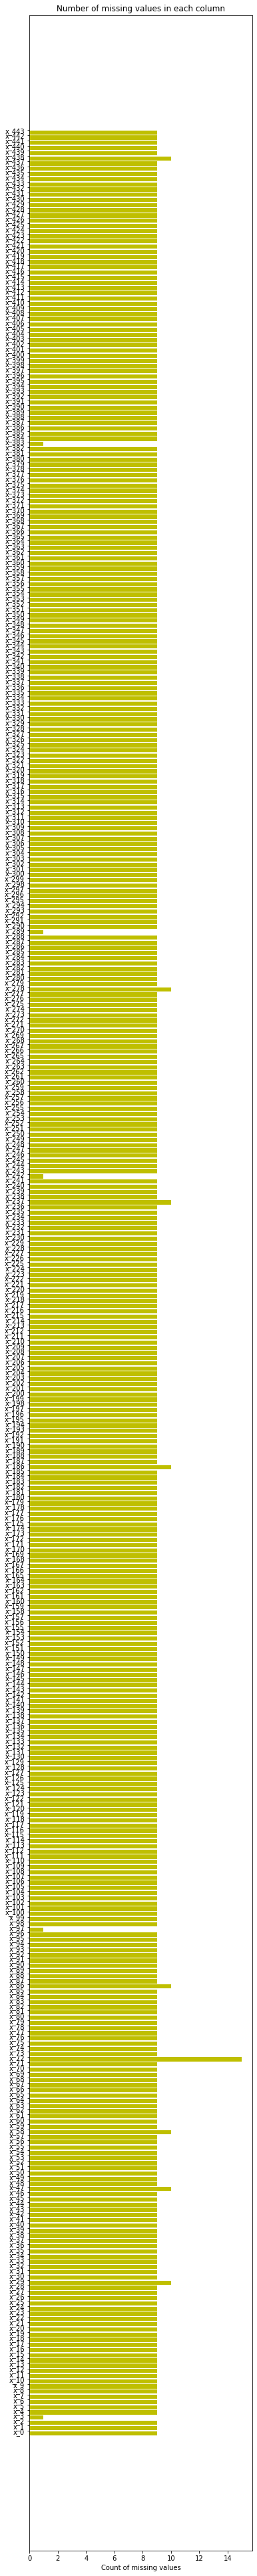

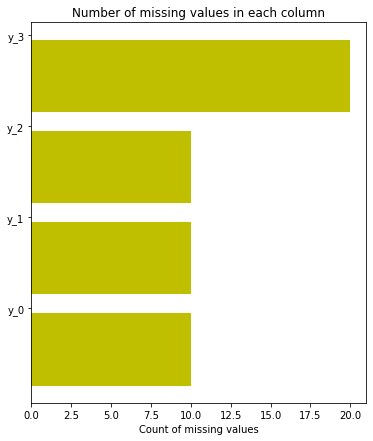

In [3]:
#plotting number of missing values in each column of data 
def missing_values(data):
    names = []
    values = []

    for col in data.columns:
        names.append(col)
        values.append(data[col].isnull().sum())
    ind = np.arange(len(names))
    width = 0.9
    if len(data.columns)> 50:
        fig, ax = plt.subplots(figsize = (6,70))
    else:
        fig, ax = plt.subplots(figsize = (6,7))
    rects = ax.barh(ind, np.array(values), color = 'y')
    ax.set_yticks(ind+((width)/2.))
    ax.set_yticklabels(names, rotation='horizontal')
    ax.set_xlabel("Count of missing values")
    ax.set_title("Number of missing values in each column")
    #autolabel(rects)
    plt.show()

missing_values(data)
missing_values(Y)


The following cell contains functions for data imputation and rejecting the outliers. However, in order to remove/reject the outliers, we need to make sure that they are actual outliers. First, we plot the time series and assess when the outliers happen. Usually in financial market, when an event happens (eg. Brexit) most of the time sereis within a same asset class observe a spike or jump. Therefore, these spikes could not be considered an outlier. If an outliers happen only for a handful time series, then these timeseries requrie further investigation. If the jump either positive or negative is ligit, we should not remove the outliers. Otherwise they should be removed.

Here, for most of the target values, we did not observe outliers. However, for the predictors we observe larger return for most of them in a same date. Therefore, we do not remove that outlier as we assume that something has happend in the market for that date. 

As for missing values, we observe nan values for all the time series. Some of the missing values are consecutive. For example there are 21 consecutive missing points for target security $y_3$. Particularly for consecutive gaps, data imputation techniques such as linear interpolation, mean values or backward and foreward fillings do not produce good resuls. K-nearest neighbur is not a good technique for time seris with differnet range of values. We use [Brownian Bridge](https://en.wikipedia.org/wiki/Brownian_bridge) to fill the gaps. Then for the non consecutive missing values linear interpolation is used. 

In [3]:
#data cleaning
# rejecting outliers
def reject_outliers(data, m=5):
    return data[abs(data-np.median(data)) < m * np.std(data)]


# return settings which could either be absolute or proportional
def return_settings(data, method= 'proportional'):
    if method =='absolute':
        return data.diff()[1:]  #absolute return 
    elif method == 'proportional':
        return data.pct_change()[1:] #proportional return
    else:
        raise Exception("The method value is not valid")

# volatility used to build the brownian bridge         
def volatility_sigma(data):
    idxNan = [i for i,x in enumerate(~(np.isnan(data))) if x]
    vol = np.std(np.diff(data[idxNan])/np.sqrt(np.diff(idxNan)))
    return vol

def brownian_bridge(x0,y0,xt,yt,vol,pathNum = 1):
    #input:
    #x0,y0,xt,yt: coordinates of start and enad points
    #vol: scale factor
    #pathNum: number of paths generated
    
    
    #return:
    #brownian bridge sample path
    
    #tTotal = (xt-x0).days
    tTotal = (xt-x0)
    steps = tTotal-1
    
    tt = np.linspace(0,tTotal, steps +2)
    
    dt = tTotal /(steps+1)
    dtSqrt = np.sqrt(dt)
    
    #Guassian increments
    bb = np.zeros((pathNum, steps+2))
    bb[:,0] = 0.0
    shift = y0 + (yt-y0)*tt/tTotal
    bb[:,1:] = np.cumsum(np.random.randn(pathNum, steps +1)*vol*dtSqrt,
                        axis = 1)
    bb = bb- bb[:,-1].reshape(pathNum, -1)*tt/tTotal + shift
    
    return bb
    
def data_augment(data, date_range, pathNum= 1):
    interpolCount = 0
    
    for iterJ in range(1,data.shape[1]):
        vol_all = volatility_sigma(np.asarray(data.iloc[:,iterJ]).astype(float))
        if np.isnan(vol_all): vol_all = 1.0
            
        iterI = 0
        flag = data.iloc[iterI, iterJ]
        while np.isnan(flag) == True:
            iterI +=1
            flag = data.iloc[iterI,iterJ]
        data.iloc[0,iterJ] = data.iloc[iterI,iterJ]
        
        iterI = -1
        flag = data.iloc[iterI, iterJ]
        
        while np.isnan(flag) == True:
            iterI -=1
            flag = data.iloc[iterI, iterJ]
        data.iloc[-1, iterJ] = data.iloc[iterI, iterJ]
        
        iterStart = 0
        flag = data.iloc[iterStart, iterJ] 
        
        while np.isnan(flag) == True:
            iterStart +=1
            flag = data.iloc[iterStart, iterJ]
            
        iterEnd = -1
        flag = data.iloc[iterEnd, iterJ]
        while np.isnan(flag) == True:
            iterEnd -=1
            flag = data.iloc[iterEnd, iterJ]
        iterI = iterStart
        while iterI < data.shape[0] + iterEnd:
            iterI +=1
            flag = data.iloc[iterI, iterJ]
            while np.isnan(flag) == True:
                interpolCount +=1
                iterI +=1
                flag = data.iloc[iterI, iterJ]
            
            
            if interpolCount != 0:
                gap = interpolCount + 1
                idx = [iter for iter, x in enumerate(
                    date_range.month == date_range[iterI-gap].month) if x]
                dCoor = np.asarray(data.iloc[idx,iterJ]).astype(float)
                vol = volatility_sigma(data.iloc[:,iterJ])
                if np.isnan(vol): vol = vol_all
                
                bb = brownian_bridge(0,data.iloc[iterI - gap, iterJ],gap, 
                                    data.iloc[iterI, iterJ], vol, pathNum )
                data.iloc[iterI - gap:iterI + 1, iterJ] = np.squeeze(bb)
                
                interpolCount = 0
    return data
                          
def impute_data(data, method ,missing_values = np.nan, n_neighbors= 5, 
                weights = 'uniform'):
        
        if method == 'knn':
            imputer = KNNImputer( missing_values,n_neighbors, weights)
            data= pd.DataFrame(imputer.fit_transform(data),
                                   columns=data.columns, index=data.index)
       # bb for brownian bridge
        elif method == 'bb':
            date_start = pd.Timestamp(data.index[0])
            date_end = pd.Timestamp(data.index[data.shape[0]-1])
            date_range = pd.date_range(date_start, date_end, freq = 'B')
            return data_augment(data,date_range)
        
        elif method == 'ffill':
            for col in data.columns:
                data[col].fillna(method = method, inplace= True)
            return data
        elif method == 'bfill':
            for col in data.columns:
                data[col].fillna(method = method, inplace = True)
            return data
        elif method == 'mean':
            for col in data.columns:
                data[col].fillna(data.mean(), inplace = True)
            return data
        elif method =='linear':
            for col in data.columns:
                data[col].interpolate(method= 'linear', inplace = True)
            return data
        else:
            raise Exception("The imputation method is not defined")
        


In [4]:
# replace the NaNs
data = impute_data(data, 'bb')
data = impute_data(data, 'linear')
Y = impute_data(Y, 'bb')
Y = impute_data(Y, 'linear') 



data_return = return_settings(data, 'proportional')
Y_return = return_settings(Y, 'proportional')
#print(Y.describe())
#print(Y_return.describe())
#print(data_return.describe())

Plotting actual observed prices of each target security
Plotting the return values of each target security


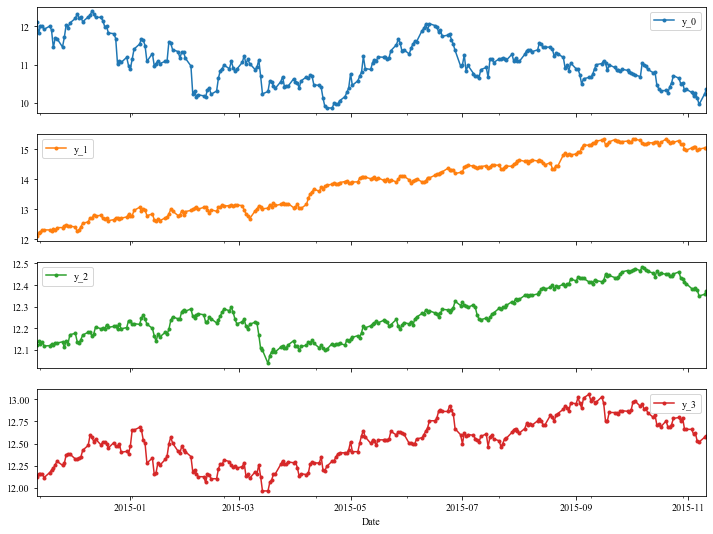

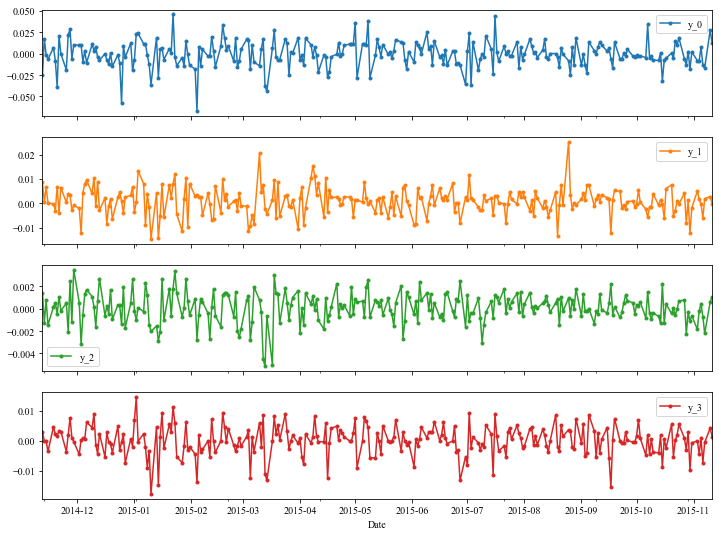

In [6]:
# plotting the target return 
def plot_ts(ts):
    mpl.rcParams['font.family'] = 'Times New Roman' 
    fig, axes = plt.subplots(len(ts.columns),1, figsize=(12,9), sharex=True)
    ts.plot(subplots=True, ax=axes, marker='o', ms=3)


print("Plotting actual observed prices of each target security")
plot_ts(Y)

print("Plotting the return values of each target security")
plot_ts(Y_return)


# Modeling

In the following cell we pick the top correlated single names from $X$ for each target value $y$. We use these regressors in the multivariate linear regression. We use all 262 points of data to find the correlation and pick the regressors.  

<bound method NDFrame.head of     y_0    y_1    y_2    y_3
0   x_6  x_162  x_226  x_124
1  x_50  x_114  x_127  x_109
2   x_1  x_124  x_270  x_133
3  x_40  x_222  x_295   x_82
4  x_31   x_88  x_109   x_88>


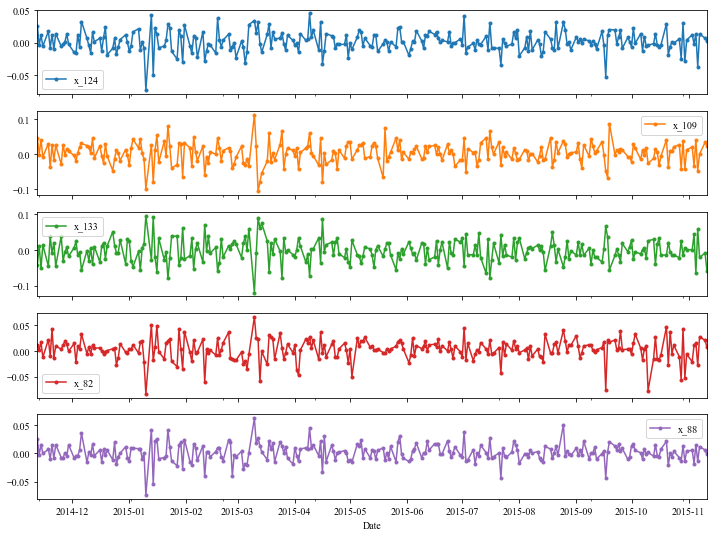

In [63]:
# compute correlation between each target and each security and return top n 
# single names as potential regressors
def get_topregressors(data, Y, num= 5):
    corMatrix = pd.concat([data,Y], axis = 1).corr().filter(Y.columns).filter(
            data.columns, axis = 0)
    abscorMatirx = abs(corMatrix)
    regMatrix = pd.DataFrame(abscorMatirx.index[np.argsort(
            -abscorMatirx.values, axis = 0)])
    regMatrix.columns = Y.columns
    regMatrix = regMatrix.iloc[:num]
    regressors = {}
    for name in Y.columns:
        regressors[name] = data[regMatrix[name]]
    return regMatrix, regressors


regMatrix, regressors = get_topregressors(data_return, Y_return)

print(regMatrix.head)
plot_ts(data_return[regMatrix['y_3']])

## Correlations of Features 

plotting corrlation matrix of top regressors


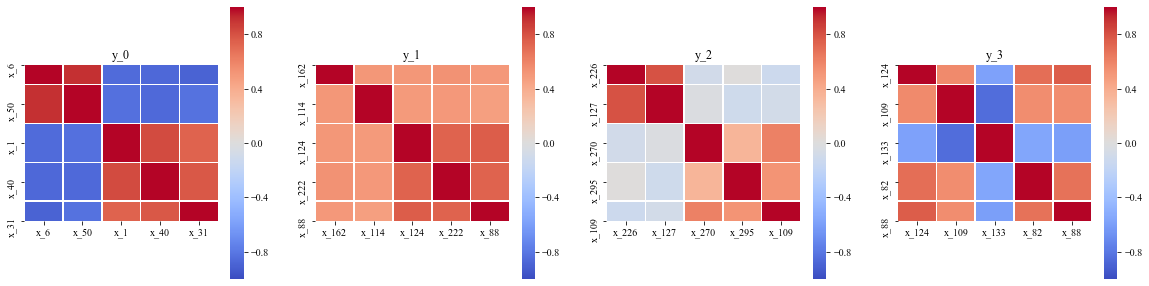

In [64]:
i = 0

print("plotting corrlation matrix of top regressors")
fig, axes = plt.subplots(1, len(regMatrix.columns), figsize=(20, 5))
for key, dat in regressors.items():
    ax = sns.heatmap(dat.corr(), linewidths=0.5,ax = axes[i], square = True,
                     cmap='coolwarm', vmax = 1, center= 0, vmin = -1)
    ax.set_title(key)
    i+=1
       

Plotting scatter plot of each regressor with the target security


/Users/ilnaz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


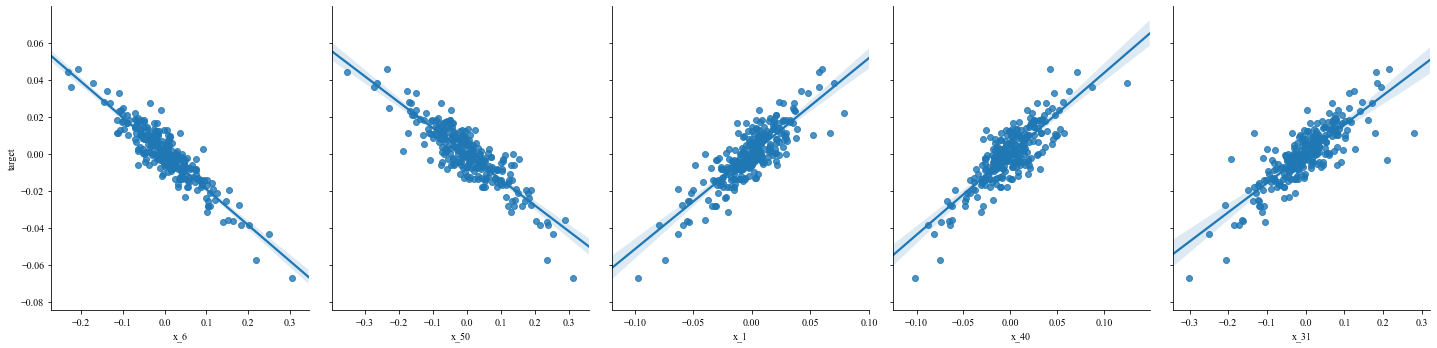

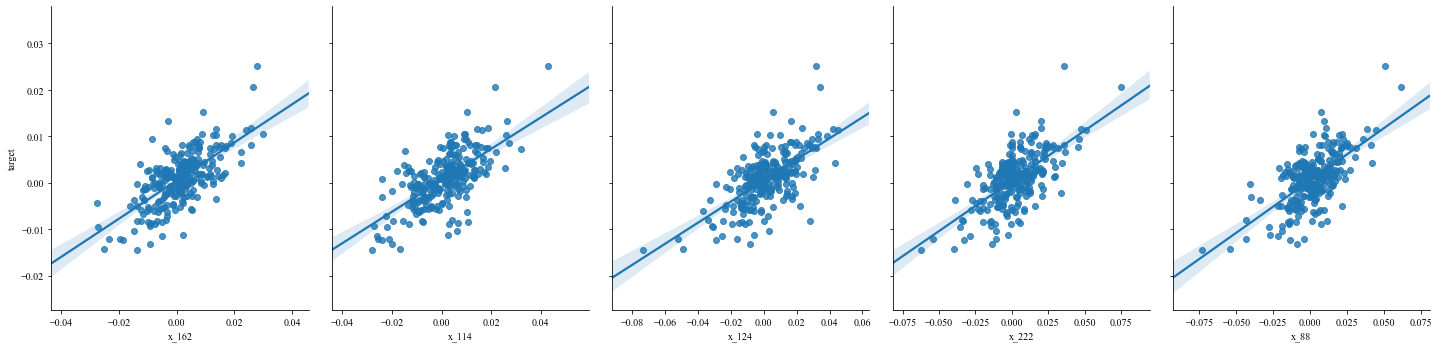

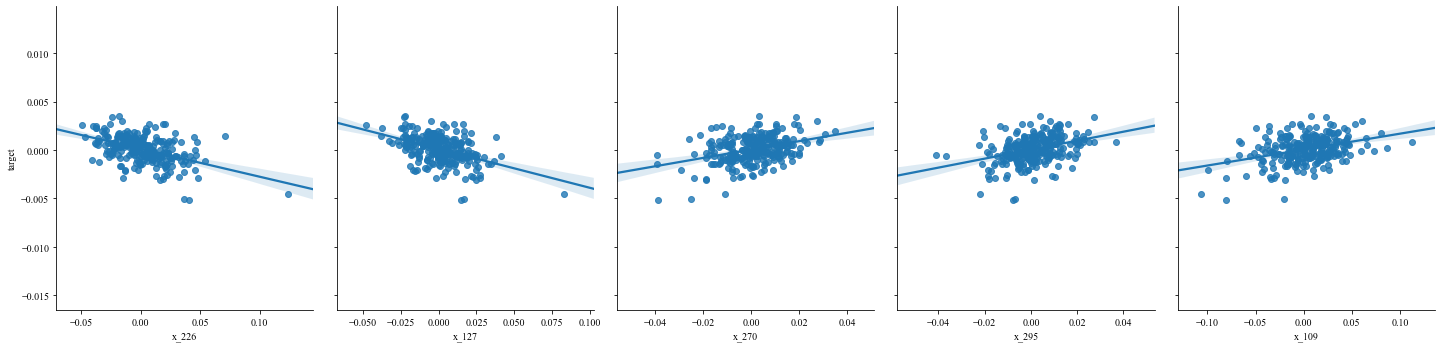

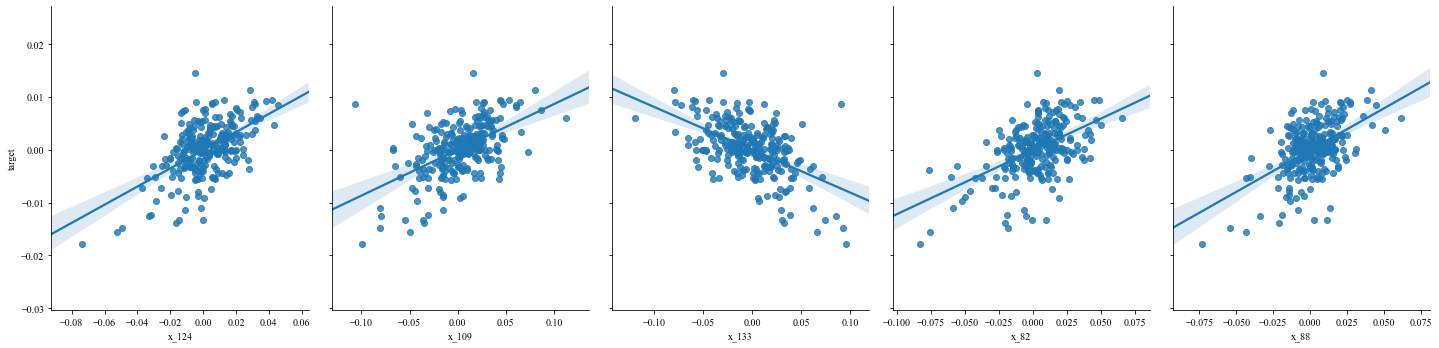

In [65]:
# Scatter plot of each target security with top regressors
print("Plotting scatter plot of each regressor with the target security")
for key, dat in regressors.items():
    dat['target'] = Y_return[key].values
    sns.pairplot(dat, x_vars= list(regMatrix[key].values),
                 y_vars= 'target', height= 5,aspect=.8, kind="reg")
    
 

We need to normalize the data as the returns are not in a same scale.

In [66]:
# set up of different metrics

def calc_train_error(x_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(x_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse

def calc_validation_error(x_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(x_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse

def calc_metrics(x_train, y_train, x_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(x_train, y_train)
    train_error = calc_train_error(x_train, y_train, model)
    validation_error = calc_validation_error(x_test, y_test, model)
    return train_error, validation_error

# mean absolute percentage error, returns in percentage multiply to 100
def mape(y,y_predict):
    temp = np.array([y, y_predict])
    y, y_pred = check_array(temp)

    return np.mean(np.abs((y - y_pred) / y)) 

In [67]:
# plot the results 


def plot_predictions(predictions, estimations):
    ax= estimations['Actual'].plot(label="Actual test set", linewidth=1, color = 'b')
    estimations['Estimated'].plot(ax = ax, label='Estimated test set', figsize =
           (13,7), alpha = 1,color ='r',linewidth=1)
    predictions['Actual'].plot(ax = ax, label= 'Actual train set',
           linewidth=1, color = 'lime')
    predictions['Predicted'].plot(ax = ax, label = 'Estimated train set',
           linewidth=1, color = 'coral')
    ax.fill_between(predictions.index,
                predictions.iloc[:,0],
                predictions.iloc[:,1], color = 'k', alpha = 0.25)
    plt.legend()
    plt.show()

    
def plot_metrics(dt, xlabel_string):
    fig = plt.figure(figsize = (18,18))
    ax1 = fig.add_subplot(331)
    ax1.plot(dt['score_t'].values, color = 'r',marker = '.')
    ax1.plot(dt['score_v'].values, color = 'b',marker = '.')
    plt.xlabel(xlabel_string)
    plt.ylabel("$R^{2}$ score")
    plt.legend(['Calibrated','Cross Validation'])

    ax2 = fig.add_subplot(332)
    ax2.plot(dt['mse_t'].values, color = 'r',marker = '.')
    ax2.plot(dt['mse_v'].values, color = 'b',marker = '.')
    plt.xlabel(xlabel_string)
    plt.ylabel("Mean Square Error")
    plt.legend(['Calibration','Cross Validation'])

    ax3 = fig.add_subplot(333)
    ax3.plot(dt['mape_t'].values, color = 'r',marker = '.' )
    ax3.plot(dt['mape_v'].values, color = 'b',marker = '.')
    plt.xlabel(xlabel_string)
    plt.ylabel("Mean Absolute Percentage Error")
    plt.legend(['Calibration','Cross Validation'])
    
    plt.show()

## Linear Regression
For the linear regression, we split the series into train and test sets using Time sereis split function. In order to have at least 40 points for the first regression we use n_splits = 6. In future for any hyperparameters of the algorithm, we should use gridserachCV to test different values of each hyperparameter. 


In [68]:
# Linear Regression 
#Input:
# xCoor, yCoor, model
np.random.seed(42)
def Regression(xCoor, yCoor, model, params, n_splits = 6 ,plot = True):
    tscv = TimeSeriesSplit(n_splits = 6)
    model = model(**params)
    predicted = {}
    estimated = {}
    mse_t = []
    mse_v = []
    mape_t = []
    mape_v = []
    score_t = []
    score_v = []
    metrics = pd.DataFrame([], columns=['mse_t','mse_v','mape_t','mape_v','score_t','score_v'])
    i =1
    for train_idx, test_idx in tscv.split(xCoor.index):
        x_train, x_test= xCoor.loc[xCoor.index[train_idx]], xCoor.loc[xCoor.index[test_idx]]
        y_train, y_test= yCoor.loc[yCoor.index[train_idx]], yCoor.loc[xCoor.index[test_idx]]
        
        reg = model.fit(x_train, y_train)
        
        predictions = pd.DataFrame()
        y_test_predicted = reg.predict(x_test)
        y_train_predicted = reg.predict(x_train)
        
        predictions['Predicted'] = y_test_predicted 
        predictions['Actual'] = y_test.values
        predictions.index = y_test.index
        predicted[str(i)+'th_batch'] = predictions
        
        estimations = pd.DataFrame()
        estimations['Estimated'] = y_train_predicted
        estimations['Actual'] = y_train.values
        estimations.index = y_train.index
        estimated[str(i)+'th_batch'] = estimations
        
        
        train_error, val_error = calc_metrics(x_train, y_train, x_test, y_test, model)
        mse_t.append(train_error)
        mse_v.append(val_error)
        
        mape_t.append(mape(y_train,y_train_predicted))
        mape_v.append(mape(y_test,y_test_predicted))
                      
        
        score_t.append(r2_score(y_train,y_train_predicted))
        score_v.append(r2_score(y_test, y_test_predicted))
                      
      
        i +=1
        if plot:
            print("Mean square error of train set is {}".format(train_error))
            print("Mean square error of test set is {}".format(val_error))
            print("Mape of train set is {}".format(mape(y_train,y_train_predicted)))
            print("Mape of test set is {}".format(mape(y_test,y_test_predicted)))
            plot_predictions(predictions, estimations)
    
    #residuals
    residuals = {}
    residuals['train_res'] = y_train_predicted - y_train
    residuals['test_res'] = y_test_predicted - y_test
    
    metrics = pd.DataFrame([mse_t,mse_v,mape_t,mape_v,score_t,score_v]).transpose()
    metrics.columns = ['mse_t','mse_v','mape_t','mape_v','score_t','score_v']
                           
    coefs = reg.coef_
    coefs = reg.coef_
    return estimated, predicted, metrics, coefs, residuals
        
    


Mean square error of train set is 1.4374658959023936e-06
Mean square error of test set is 1.6804812282980124e-06
Mape of train set is 1.076674683203375
Mape of test set is 1.136318330349944


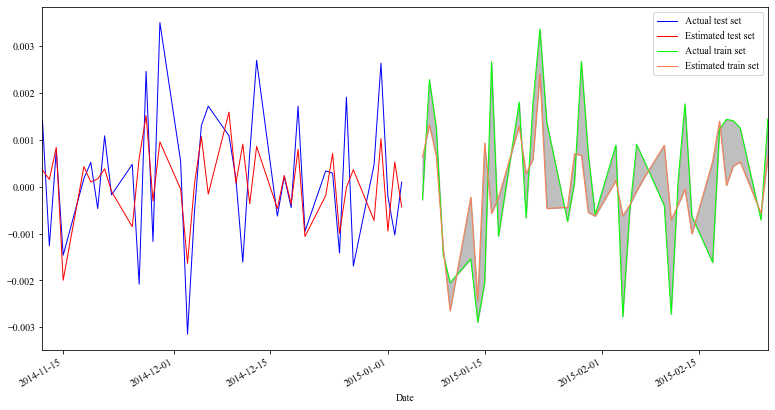

Mean square error of train set is 1.528403604945243e-06
Mean square error of test set is 1.7509765812002637e-06
Mape of train set is 1.1062094840564427
Mape of test set is 1.0974179554987513


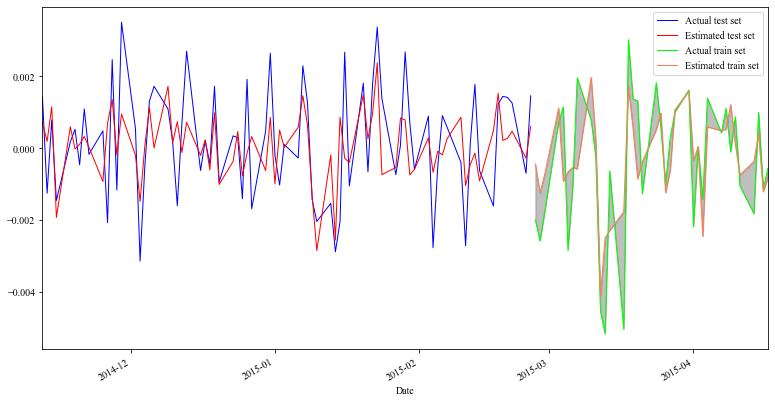

Mean square error of train set is 1.566342492034139e-06
Mean square error of test set is 1.0236192270102792e-06
Mape of train set is 1.2030260806657525
Mape of test set is 1.2348339931872945


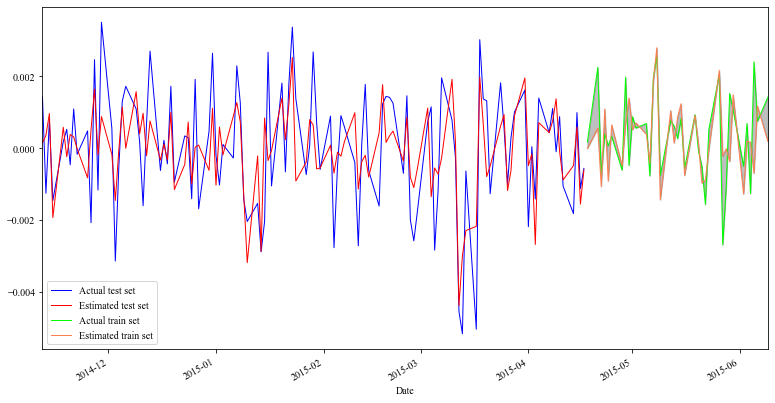

Mean square error of train set is 1.4157883426847854e-06
Mean square error of test set is 7.507963906700061e-07
Mape of train set is 1.1859558036762827
Mape of test set is 1.498344007657742


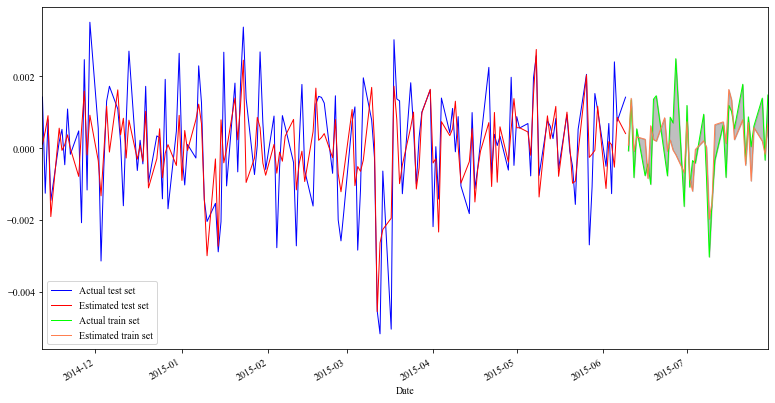

Mean square error of train set is 1.276964837314912e-06
Mean square error of test set is 7.820843702165064e-07
Mape of train set is 1.2510864254791796
Mape of test set is 2.940841509824148


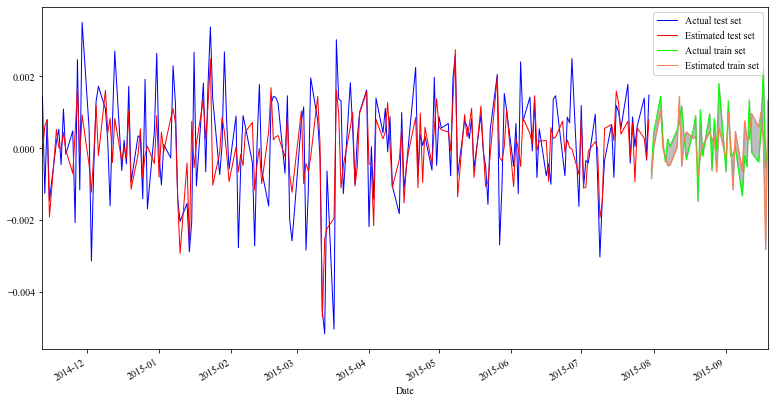

Mean square error of train set is 1.18511623870695e-06
Mean square error of test set is 5.329141801123846e-07
Mape of train set is 1.4895532987467297
Mape of test set is 1.1156612274213777


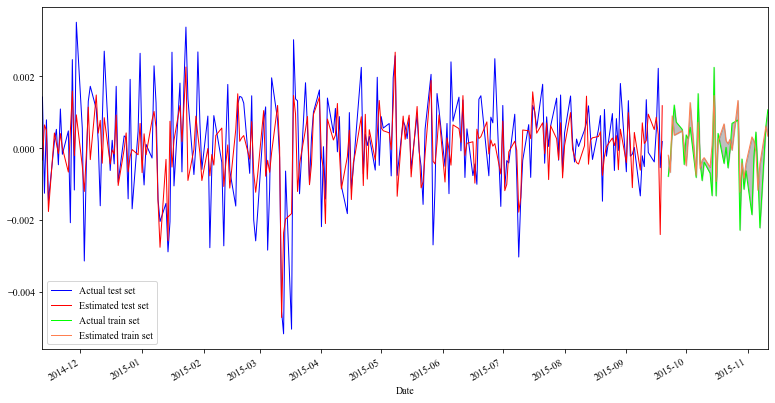

In [69]:
# testing the results for simple linear regression (base model)
# parameters of the model
regMatrix, regressors = get_topregressors(data_return, Y_return,num=5)
params = {'fit_intercept': False, 
 'normalize': True}
xCoor0 = regressors['y_2']
yCoor0 = Y_return['y_2']
model = LinearRegression
estimated0, predicted0, metrics, coefs, residuals  = Regression(xCoor0, yCoor0,model, params, n_splits=7) 


security names and the corresponding weights for the basket of target security y_0 is
[('x_6', -0.083), ('x_50', -0.039), ('x_1', 0.135), ('x_40', 0.015), ('x_31', 0.016)]
security names and the corresponding weights for the basket of target security y_1 is
[('x_162', 0.196), ('x_114', 0.149), ('x_124', 0.05), ('x_222', 0.041), ('x_88', 0.054)]
security names and the corresponding weights for the basket of target security y_2 is
[('x_226', -0.016), ('x_127', -0.018), ('x_270', 0.027), ('x_295', 0.033), ('x_109', 0.002)]
security names and the corresponding weights for the basket of target security y_3 is
[('x_124', 0.084), ('x_109', 0.023), ('x_133', -0.025), ('x_82', 0.031), ('x_88', 0.01)]


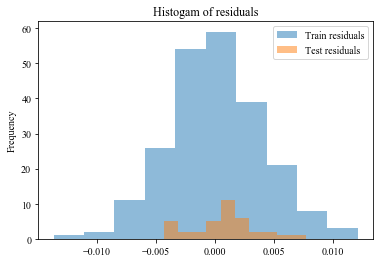

In [70]:
# plotting the error metrics of each target security
basket_weights = {}
xlabel_string = "Batch of time series splits"
for col in Y_return.columns:
    xCoor = regressors[col]
    yCoor = Y_return[col]
    _,_, metrics, coefs, residuals  = Regression(xCoor ,yCoor,model ,params ,plot=False)
    basket_weights[col]= list(zip(xCoor.columns, coefs.round(3)))
    
for key, items in basket_weights.items():
    print("security names and the corresponding weights for the basket of target security {} is".format(key),
          "{}".format(items), sep = '\n')

fig, ax = plt.subplots()
residuals['train_res'].plot.hist(density= False, ax = ax,alpha = 0.5,
                                title = "Histogam of residuals")
residuals['test_res'].plot.hist(density= False, ax = ax,alpha = 0.5,
                                )
plt.legend(['Train residuals', 'Test residuals'])

    

    
    


## Least Angle Regression (LARS)  
 
One algorithm that we can apply when have high dimensional data is least angle regression [LARS](https://en.wikipedia.org/wiki/Least-angle_regression), [LARS Paper](http://statweb.stanford.edu/~tibs/ftp/lars.pdf). LARS is similar to forward stepwise regression and computationally as fast as forward selection and tt is effective in contexts where $p >> n$ (i.e., when the number of dimensions is significantly greater than the number of points.  

Mean square error of train set is 5.9537622939882365e-05
Mean square error of test set is 0.00019103823024523077
Mape of train set is 1.693483948882009
Mape of test set is 2.075699734442584


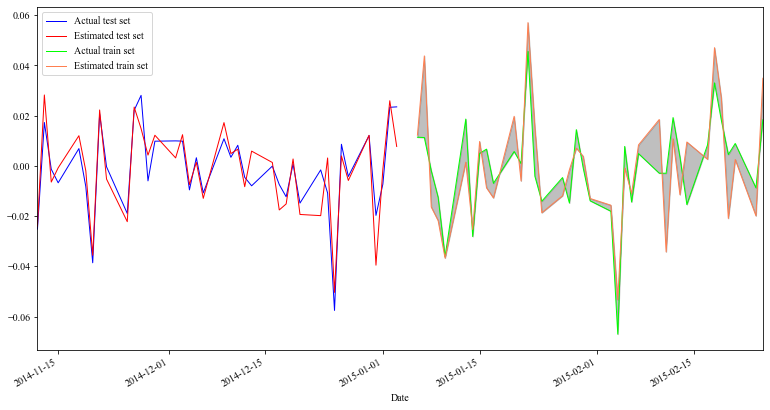

Mean square error of train set is 2.684279283938299e-05
Mean square error of test set is 0.0001213776107866812
Mape of train set is 1.473188159735599
Mape of test set is 2.492199462056568


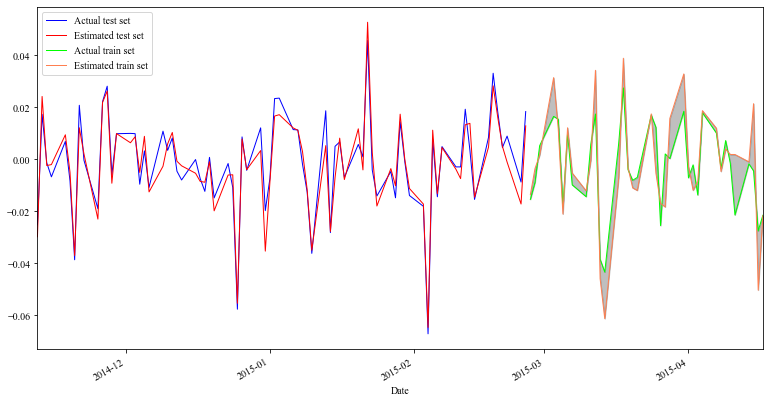

Mean square error of train set is 4.0468635872368905e-05
Mean square error of test set is 0.0005132241869287828
Mape of train set is 1.6173460002296591
Mape of test set is 2.9428301752724466


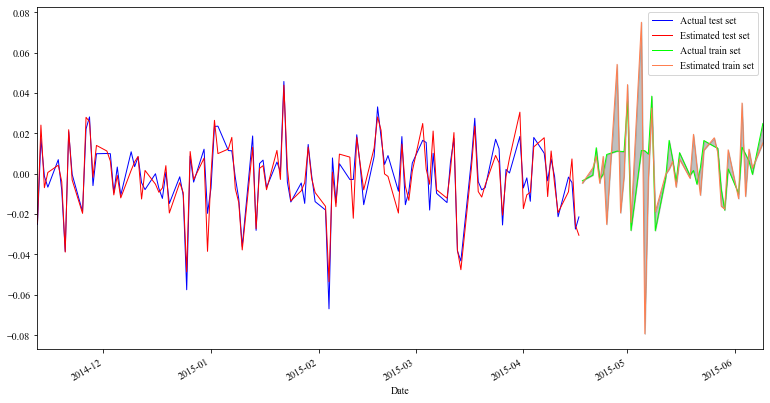

Mean square error of train set is 3.581521836125202e-05
Mean square error of test set is 4.8624396803497857e-05
Mape of train set is 1.016973967041621
Mape of test set is 1.518599852038563


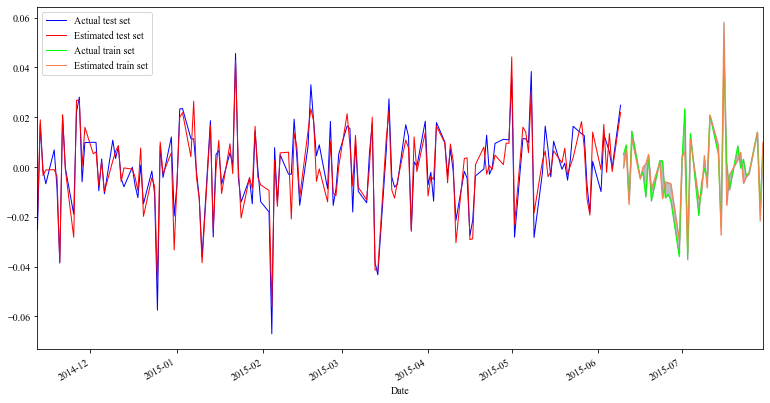

Mean square error of train set is 4.883945839171787e-05
Mean square error of test set is 9.371966974436494e-05
Mape of train set is 1.3655107642521778
Mape of test set is 25.819728339999653


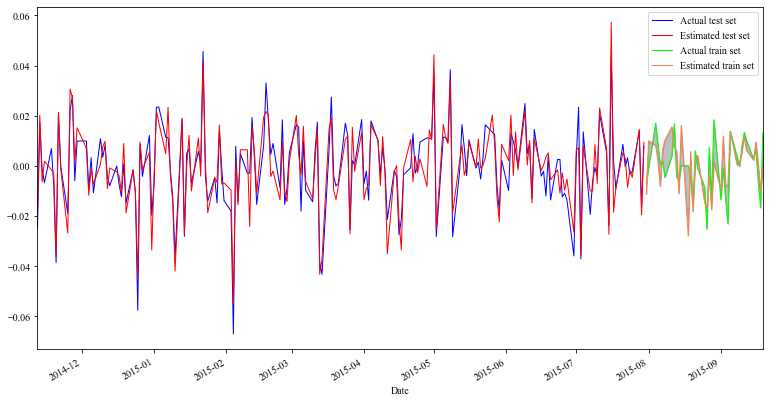

Mean square error of train set is 2.67603693060815e-05
Mean square error of test set is 4.3616602265034404e-05
Mape of train set is 1.9746610460396081
Mape of test set is 2.3557223476864455


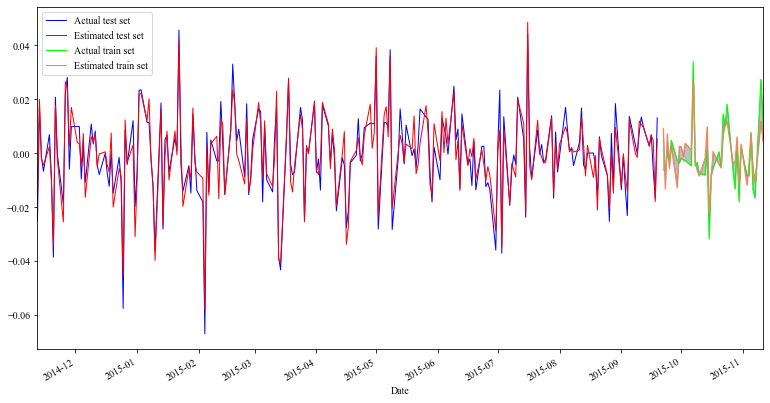

In [71]:
# testing LARS method 
# parameters of the model
params = {'fit_intercept': False, 
 'normalize': True}
regMatrix, regressors = get_topregressors(data_return, Y_return, num=15)

xCoor0 = regressors['y_0']
yCoor0 = Y_return['y_0']

model = Lars
estimated_lars, predicted_lars, metrics_lars, coefs_lars, residuals_lars  = Regression(xCoor0, yCoor0,model, params, n_splits=3) 




In [72]:
# plotting the error metrics of each target security
basket_weights = {}
model = Lars
xlabel_string = "Batch of time series splits"
for col in Y_return.columns:
    xCoor = regressors[col]
    yCoor = Y_return[col]
    _,_, metrics, coefs, residuals  = Regression(xCoor0, yCoor0,model, params, n_splits=3 ,plot=False)
    basket_weights[col]= list(zip(xCoor.columns, coefs.round(3)))
    
for key, items in basket_weights.items():
    print("security names and the corresponding weights for the basket of target security {} is".format(key),
          "{}".format(items), sep = '\n')

security names and the corresponding weights for the basket of target security y_0 is
[('x_6', -0.081), ('x_50', -0.031), ('x_1', 0.135), ('x_40', 0.0), ('x_31', 0.015), ('x_185', 0.004), ('x_41', 0.113), ('x_145', 0.006), ('x_214', -0.016), ('x_133', 0.021), ('x_109', 0.004), ('x_311', 0.0), ('x_231', 0.011), ('x_154', 0.023), ('x_79', 0.05)]
security names and the corresponding weights for the basket of target security y_1 is
[('x_162', -0.081), ('x_114', -0.031), ('x_124', 0.135), ('x_222', 0.0), ('x_88', 0.015), ('x_75', 0.004), ('x_60', 0.113), ('x_125', 0.006), ('x_10', -0.016), ('x_55', 0.021), ('x_53', 0.004), ('x_204', 0.0), ('x_39', 0.011), ('x_59', 0.023), ('x_90', 0.05)]
security names and the corresponding weights for the basket of target security y_2 is
[('x_226', -0.081), ('x_127', -0.031), ('x_270', 0.135), ('x_295', 0.0), ('x_109', 0.015), ('x_6', 0.004), ('x_311', 0.113), ('x_193', 0.006), ('x_219', -0.016), ('x_40', 0.021), ('x_221', 0.004), ('x_123', 0.0), ('x_84', 

### Comparing Linear Regression results and Lars

There is no significant improvement in the results of Lars over the simple linear regression. Moreover, the number of regressors in the Lars algorithm is much higher than linear regression. I expected to see many zero-value coefficients


## Principal Component Regression (PCR)

Instead of regressing the target values on the features (securities) directly, the pricipal components of the explanatory variables are used as regressors. Given the fact that most of the provided securities are typically highly liquid and readily available to buy or sell, my assimption is we can make an ETF product based on the contribution of each security. 

Each principal component provides the contribution weight of each security. Therefore, we can assume each principal component works similar to an ETF. 

In order to start the PCA approach, for each target, first we pick 20 ~ 40 highly correlated features among 444 securities. Then perform the PCA on the data matrix of the features. Then using the ordinary least square regression we get a vector of extimated regression coefficients with dimension equal to the number of selected principal components (maximum 5). 


In [73]:
# pca with regression approach

def pca_regression(xCoor, yCoor, n_comp = 5, return_names =False, return_weights= False):
    ''' Principal Component Regression in Python'''
    ''' Step 1: PCA on input data'''

    pca = PCA()
    ''' smoothing the input using Savitzky-Golay filter 
    --> this step could be removed, works as getting the 
    1st derivative over a given window'''
    
    x_d1 = savgol_filter(xCoor, 19, polyorder = 5, deriv = 1)
    columns = xCoor.columns
    xCoor = StandardScaler().fit_transform(x_d1)
    print
    pca_comp = pca.fit_transform(xCoor)[:,:n_comp]
    #print(np.cumsum(pca.explained_variance_ratio_))
    
    linreg = LinearRegression()
    
    # fit
    linreg.fit(pca_comp, yCoor)
    
    #calibrate
    y_pred = linreg.predict(pca_comp)
    
    #cross-validation
    y_crossval = cross_val_predict(linreg, pca_comp, yCoor, cv = 10)
    
    error_dict = {} 
    #get scores of cross validation
    error_dict['score_t'] = r2_score(yCoor, y_pred)
    error_dict['score_v'] = r2_score(yCoor, y_crossval)
    
    # Calculate mean square error for calibration and cross validation
    error_dict['mse_t'] = mean_squared_error(yCoor, y_pred)
    error_dict['mse_v'] = mean_squared_error(yCoor, y_crossval)
    
    # Calculate mean absolute percentage error for calibration and validation
    error_dict['mape_t'] = mape(yCoor, y_pred)
    error_dict['mape_v'] = mape(yCoor, y_crossval)
    
    n_pc = pca.n_components_
    # get the index of the most important feature on EACH component
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pc)]
    # get the most important feature names
    most_important_names = [columns[most_important[i]] for i in range(n_pc)]
    
    if return_names and not return_weights:
        
        return (y_crossval, error_dict, most_important_names)
    if return_weights:
        weights = linreg.coef_
        return(y_crossval, error_dict, most_important_names, weights)
    
    return(y_crossval, error_dict)



In order to build the calibration model, for different number of pca components the above function is run. The metric that we compare here is R_square of calibration and cross validation and also the mean squared error and mean absolute percentage error (mape). For PCR, we used the raw data to get the pca factors. 

The optimal number of principal componets for target security y_0 is 3
Plotting $R^{2}$ score, Mean Square Error and Mean Absolute Percentage Error of PCR results for y_0


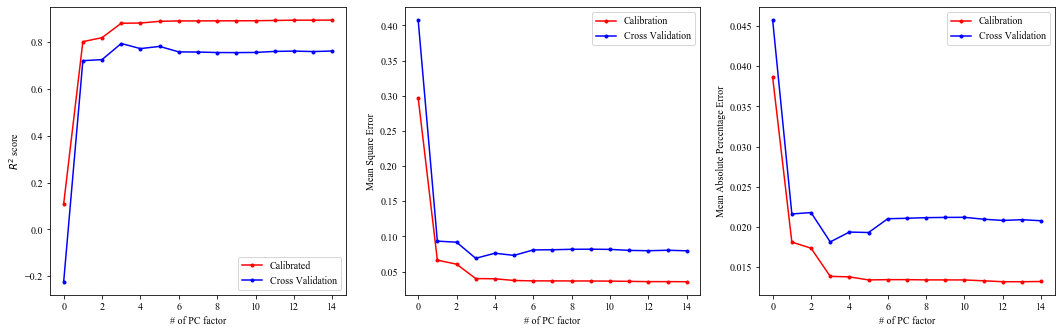

The optimal number of principal componets for target security y_1 is 5
Plotting $R^{2}$ score, Mean Square Error and Mean Absolute Percentage Error of PCR results for y_1


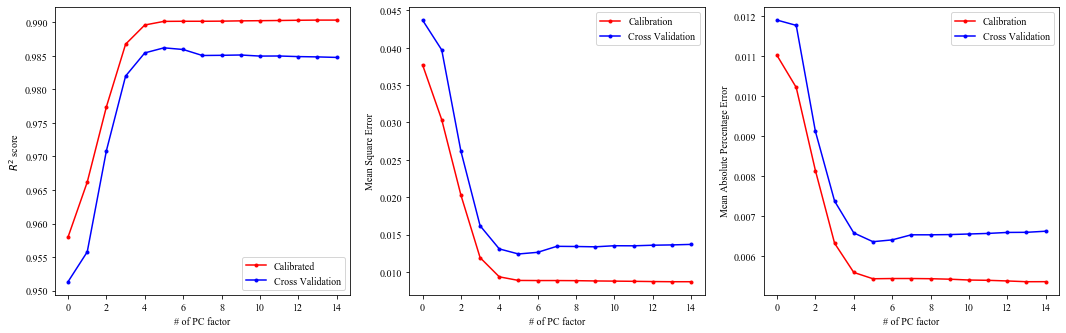

The optimal number of principal componets for target security y_2 is 5
Plotting $R^{2}$ score, Mean Square Error and Mean Absolute Percentage Error of PCR results for y_2


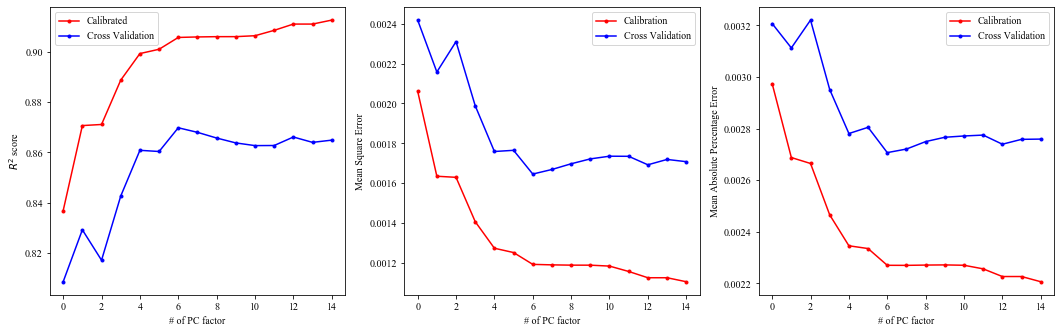

The optimal number of principal componets for target security y_3 is 5
Plotting $R^{2}$ score, Mean Square Error and Mean Absolute Percentage Error of PCR results for y_3


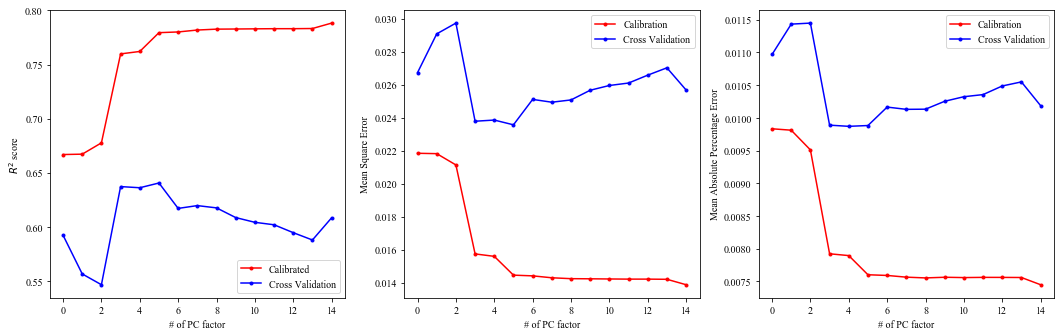

In [74]:
# get the top n regressors for pca
regMatrix, regressors = get_topregressors(data, Y, num=20)
num_pcfactor = {}
for i in range(len(Y.columns)):
    target = 'y_'+ str(i)
    xCoor = regressors[target]
    yCoor = Y[target]
    res = {}
    dt = pd.DataFrame([])
    pc_comp = 16
    for i in range(1,pc_comp):
        _, error = pca_regression(xCoor, yCoor, n_comp = i)
        temp = pd.DataFrame(error.items())
        temp = temp.transpose()
        temp.columns = temp.iloc[0]
        temp = temp.drop(temp.index[[0]])
        dt = dt.append(temp)
    num_pcfactor[target] = min(max(np.argmin(dt['mse_v'].values),1), 5)
    print("The optimal number of principal componets for target security {} is {}".format(target,
                                                                                          num_pcfactor[target]))

    print("Plotting {} score, Mean Square Error and Mean Absolute Percentage Error of PCR results for {}".format(
        '$R^{2}$',target))
    plot_metrics(dt,"# of PC factor")




         


As shown in figures above, for target value of $y_0$ all tree metrics, $R^2$, MSE and MAPE have a jump at the second pricipal component, which indicates that at least 2 factors are required to explain the data. However, the important metric is the cross validation value. Particularly, we are looking at a minimum in the $MSE_C$ values. Considering the mse and maximum of 5 regressors in each basket, we use 3 PC for target security $y_0$, and 5 for $y_1$ $y_2$ and $y_3$. 



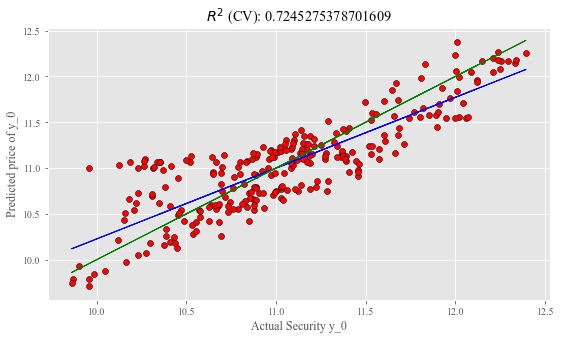

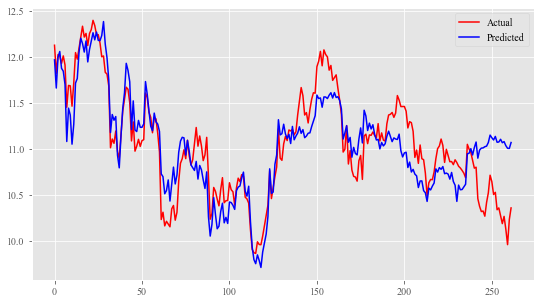

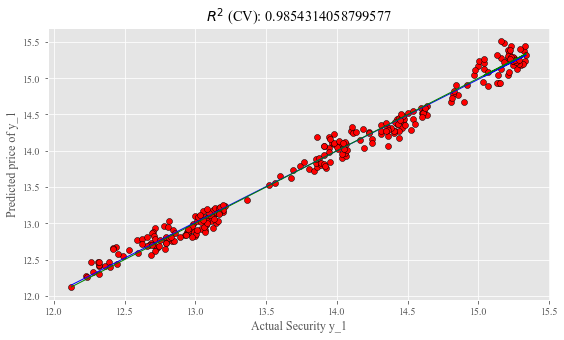

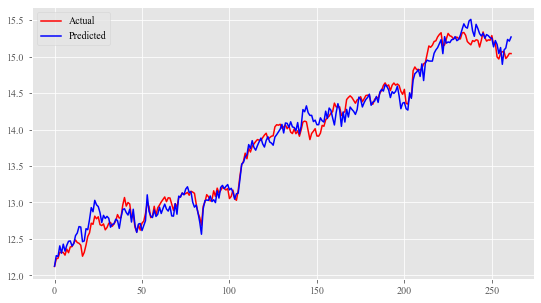

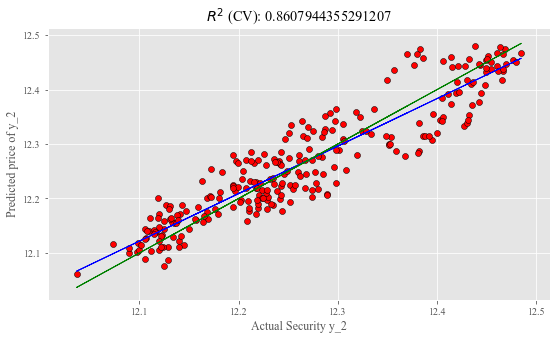

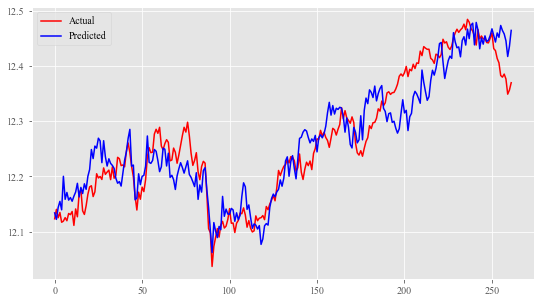

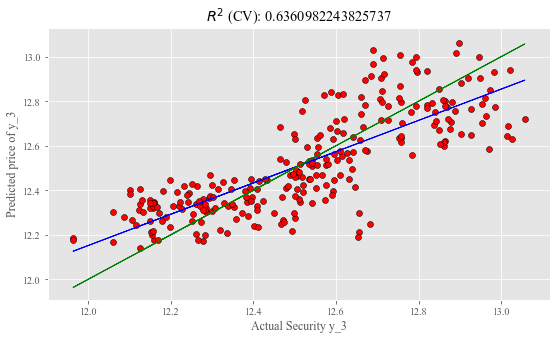

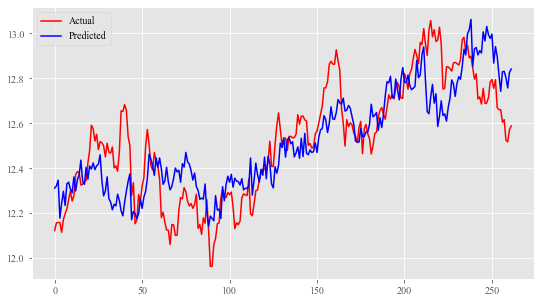

In [75]:
for i in range(len(Y_return.columns)):
    target = 'y_'+ str(i)
    xCoor = regressors[target]
    yCoor = Y[target] 

    predicted, error = pca_regression(xCoor,yCoor, num_pcfactor[target])
   
    # Regression plot
    z = np.polyfit(yCoor, predicted, 1)
    print()
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(yCoor, predicted, c='red', edgecolors='k')
        ax.plot(yCoor, z[1]+z[0]*yCoor, c='blue', linewidth=1)
        ax.plot(yCoor, yCoor, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(error['score_v']))
        plt.xlabel('Actual Security %s' %target)
        plt.ylabel('Predicted price of %s' %target)
        plt.show()
        fig, ax = plt.subplots(figsize = (9,5))
        ax.plot(yCoor.values, c = 'red')
        ax.plot(predicted, c= 'blue')
        plt.legend(['Actual', 'Predicted'])
        plt.show


The green line represent the ideal, 100% correlation between the actual price and predicted values. The blue line is the actual correlation. Given the fact that PCA is done without any knowledge of target value, we should use estimators to consider target value in feature selection as well. One possible approach is to use partial least square (PLS). PLS is based on finding a similar linear relation as to PCR but it does this by maximising the covariance between target and features. It considers both features and dependent variable and for this it improves some of the limitations of PCR. This is one approach that I will test in future. 


Also, I would like to explore stacking approach as well. I got familiar with this concept during my interview with one of the members of your team (Florian). I started learning about it and just wrote an script to get some basic resutls. However, I need to understand how we can get the weights of each regressors to build the basket. 


In [76]:
for i in range(len(Y.columns)):
    target = 'y_'+ str(i)
    xCoor = regressors[target]
    yCoor = Y[target] 

    _, _, most_important_names, weights = pca_regression(xCoor, yCoor, n_comp = 5, 
                                                         return_names =True, return_weights= True)
    print("The single names used to build ETF (pc) for {} is ".format(target),
          "{}".format(most_important_names), sep = '\n')
    print("Weights of PC for {} is".format(target),
         "{}".format(weights), sep= '\n')
   

The single names used to build ETF (pc) for y_0 is 
['x_22', 'x_6', 'x_434', 'x_236', 'x_371', 'x_1', 'x_434', 'x_371', 'x_391', 'x_358', 'x_273', 'x_30', 'x_12', 'x_74', 'x_50', 'x_6', 'x_145', 'x_185', 'x_31', 'x_40']
Weights of PC for y_0 is
[-0.05415677  0.21073211 -0.05202269 -0.30847568  0.04807685]
The single names used to build ETF (pc) for y_1 is 
['x_76', 'x_62', 'x_318', 'x_73', 'x_224', 'x_269', 'x_382', 'x_381', 'x_25', 'x_269', 'x_289', 'x_140', 'x_89', 'x_55', 'x_76', 'x_260', 'x_274', 'x_254', 'x_114', 'x_162']
Weights of PC for y_1 is
[ 0.22452044 -0.05364642 -0.20561737  0.29648191  0.24132018]
The single names used to build ETF (pc) for y_2 is 
['x_57', 'x_182', 'x_390', 'x_11', 'x_182', 'x_321', 'x_165', 'x_281', 'x_186', 'x_197', 'x_297', 'x_57', 'x_165', 'x_256', 'x_81', 'x_29', 'x_308', 'x_200', 'x_221', 'x_38']
Weights of PC for y_2 is
[ 0.02729395 -0.01030214 -0.00216982 -0.02094979 -0.0405162 ]
The single names used to build ETF (pc) for y_3 is 
['x_99', 'x_42

In [77]:
# Random Forest approach 

# hyperparameter_grid={
#                     'max_depth': [3, None],
#                     'n_estimators': [10, 30, 50, 100, 200, 400, 600, 800, 1000],
#                     'max_features': [2,4,6]
#                     }
# def RFregress(xCoor, yCoor, max_depth, n_estimator = 100):
#     mF = max(1, round(xCoor.shape[1]/3))
#     regRF = RandomForestRegressor(max_depth= max_depth, n_estimator= n_estimator,
#                                   max_features = mf, min_samples_leaf=10)
#     regRF.fit(xCoor, yCoor)
#     leaf = regRF.apply(xCoor)
#     yFR = np.zeros(yCoor.shape)
#     for iterE in range(n_estimator):
#         for iter in list(np.unique(leaf[:,iterE])):
#             idx = leaf[:, iterE] == iter
#             yRF[idx] += LinearRegression(fit_intercept=False).fit(xCoor[idx,:], yCoor[idx]).predict(xCoor[idx,:])
#     yRF = yRF/n_estimators
#     return yRF

            
    

$\textbf{How would you quantify the risk associated with the hedge you proposed}$?

The coefficient of each equity return changes with events happen in the market. We should test the weights and regressors for different window of time and find how stable the weights are. Moreover, we need to learn the correlation measures that are used to quantify the connections between each equities. What I have used is the pairwise correlation between target and each single names. All approaches in this report, have this shortcoming that they do not capture events such as large losses. 

One more issue with the approach presented here is that the covariance matrix uses correlations, which gives equal weight to positive and negative returns and to small and large returns. However, we need to learn when an event happens in the market which equities move to gether and in which direction, simply put the historical relationship between equities should be learnt. In the linear regression model, the covariates (predictors) that we've chosen are based on the assumption of having constant correlation over a period of $T$ and it is a pairwise correlation. This assumption needs improvement. 

# Capital Allocation

My thought is to choose a basket of equities that have high expected return but are probable to move down and up together (low variation). Since we observe a tradeoff between rate of return and risk, we should pick a portfolio with desired rate of return and minimum variance. Using linear regression, the coefficients of each equity in the basket provides the rate of contribution. 

If we choose top five most correlated (both positive/negative) features, the weights of each security in the basket is as follow:

security names and the corresponding weights for the basket of target security y_0 is
[('x_6', -0.083), ('x_50', -0.039), ('x_1', 0.135), ('x_40', 0.015), ('x_31', 0.016)]
security names and the corresponding weights for the basket of target security y_1 is
[('x_162', 0.196), ('x_114', 0.149), ('x_124', 0.05), ('x_222', 0.041), ('x_88', 0.054)]
security names and the corresponding weights for the basket of target security y_2 is
[('x_226', -0.016), ('x_127', -0.018), ('x_270', 0.027), ('x_295', 0.033), ('x_109', 0.002)]
security names and the corresponding weights for the basket of target security y_3 is
[('x_124', 0.084), ('x_109', 0.023), ('x_133', -0.025), ('x_82', 0.031), ('x_88', 0.01)]

If we assume that short selling is not allowed, then we only pick the top 5 most positively correlated regessors in the linear regression algorithm and the results are:

security names and the corresponding weights for the basket of target security y_0 is
[('x_1', 0.22), ('x_40', 0.08), ('x_31', 0.061), ('x_185', 0.013), ('x_41', 0.142)]
security names and the corresponding weights for the basket of target security y_1 is
[('x_162', 0.196), ('x_114', 0.149), ('x_124', 0.05), ('x_222', 0.041), ('x_88', 0.054)]
security names and the corresponding weights for the basket of target security y_2 is
[('x_270', 0.022), ('x_295', 0.024), ('x_109', 0.003), ('x_311', 0.01), ('x_219', 0.048)]
security names and the corresponding weights for the basket of target security y_3 is
[('x_124', 0.058), ('x_109', 0.03), ('x_82', 0.046), ('x_88', -0.0), ('x_79', 0.135)]


However, if we set a constraint such as no short positions, and daily readjusted portfolio weights then we need to solve the following constrint optimization:

$\min_{w} \dfrac{1}{2} w^{T}Cw$ \quad ,  subject to $ \quad \sum_{j = 1}^{5}x_j w_j \geq 0$ and $ \sum_{j = 1}^{5}W_j = 1, \quad 0 \leq w_j \leq 1$.

I am sorry that I didn't get to finish this task compeletly :(  I need a little more time to finish this part. I'd be more than happy to chat about this part with you. 

# Scaling 

Scaling works similar to the divide and conquer algorithm. We need to divide the task into smaller subtasks that could be distributed and assigned to several machines. Scaling starts with sharding the large scale input data into equal divisions, and our design determines which data processing step is suitable to be run as part of the pipeline. A good example of tasks that could be parellized are importing data, imputation, data cleaning and applying the estimators. 

$\textbf{Explain what types of technologies you would use to store your data, model, }$ 
$\textbf{and serve your model?}$

It is impossible to store all our data in a single file/database that is readable on a single machine. All existing cloud solution providers offer three major products to help us run the pipeline at scale: cloud storage, pipeline and big data processing and model management (training and serving model) products. 

To store data on cloud, we define a file/table/dataset format that represents our input data. It is expected that the format changes over time, so it's important for any changes to be backward compatible.

We suggest using a cloud data pipeline solution to expedite the process, minimizes latency, processing time, and cost through batch processing. The data pipeline solution gives us access to many machines to solve our largest data processing challenges and allows us to parallelize independent subtasks that could be processed individually.

The majority of cloud providers offer a wide range of products to host, maintain and serve models while supporting features such as versioning and labeling. It's also possible to serve some models on allocated machines/servers that are maintained by the team. 


$\textbf{How often would you train and replace the production model?}$


My suggestion is to run the trainaing pipeline regularly (once weekly/biweekly)). We can generate many models but we don't use them all for serving. We pick one candidate based on different metrics and performance measures. The candidate model is only deployed if it shows NO regression over the existing serving model.

We monitor the performance of the model and set a threshold in terms of rate of return of the portfolio. If this value hits the threshold margin, we investigate what the source is. Usually, a new market condition causes prices to spike so we include the recent points and train the model. My assumption is given how volatile the market is, and the fact that recent points (prices) should be in the training data, biweekly or monthly could be a reasonable duration. After taining the new algorithm, we compare its performance with previous model in production and if it continuosly outperform the in-production algorithm we deploy it. 


$\textbf{How do you launch, monitor, and maintain your model once it is deployed?}$

We observe how much our current algorithm is different from the previous model and we monitor the model's performance and metrics over the test/train datasets. Launching is done once the current model is better than the in-production one. After deploying the new model, we keep the previous model as well. For any reasons, if the new model does not meet our expectations, we roll back to the previous version. The model should be deployed gradually so any unexpected errors don't make it all to production. 